# Clustering to reduce $\|H\|_F$

The idea is to cluster collumns and rows

Here we have the objective function 



In [1]:
import numpy as np
import tvsclib.utils as utils
import Split
import matplotlib.pyplot as plt
from tvsclib.strict_system import StrictSystem

from tvsclib.approximation import Approximation

import torchvision.models as models
import torch
import scipy.stats 

import graphs

import scipy.linalg as linalg

import plot_permutations as perm

In [2]:
def get_mobilenet_target_mats():
    target_mats = []
    # Load the model
    model = models.mobilenet_v2(pretrained=True)
    # Put moel into eval mode
    model.eval()
    for layer in model.classifier:
        if isinstance(layer, torch.nn.Linear):
            # Obtain the weights of this layer
            weights = layer.weight.detach().numpy()
            target_mats.append(weights)
    return target_mats

## Some helping functions

In [3]:
def f(X,s_col,s_row):
    return 0

def compute_sigmasf(X,s_col,s_row):
    return np.linalg.svd(X[s_row][:,s_col],compute_uv=False), np.linalg.svd(X[~s_row][:,~s_col],compute_uv=False)

def show_matrices(X,s_col,s_row):
    plt.matshow(X[s_row][:,s_col],fignum=1)

    plt.matshow(X[~s_row][:,~s_col],fignum=2)

f_reg_row = lambda x: -gamma*x**3
f_reg_col = lambda x: -gamma*x**3

gamma = 0e4 #maxbee have two different regularizations for rows and collumns

## Iteration

In [4]:
def segment_matrix(stage_causal,stage_anticausal,N=70,initla_spectral=True): #minimize frobenius norm
    
    Ac = stage_causal.A_matrix**2
    Bc = stage_causal.B_matrix**2
    Cc = stage_causal.C_matrix**2

    Aa = stage_anticausal.A_matrix**2
    Ba = stage_anticausal.B_matrix**2
    Ca = stage_anticausal.C_matrix**2

    D = stage_causal.D_matrix**2
    
    #regularization vector
    v_reg_col = f_reg_col(np.linspace(-1,1,D.shape[1]))
    v_reg_row = f_reg_row(np.linspace(-1,1,D.shape[0]))
    
    (d_out_c_i,d_in_c_i) = Ac.shape
    (d_out_a_i,d_in_a_i) = Aa.shape

    Ac = np.eye(1)
    Bc = np.sum(Bc,axis=0)
    Cc = np.sum(Cc,axis=1)
    Aa = np.eye(1)
    Ba = np.sum(Ba,axis=0)
    Ca = np.sum(Ca,axis=1)
    
    s = np.sum(Cc)
    if s ==0:
        #Cc = np.ones((Cc.size,1))
        Cc = np.zeros((Cc.size,1))
    else:
        #Cc = (Cc*(w*Cc.size/s)).reshape(-1,1)
        Cc = Cc.reshape(-1,1)

    s = np.sum(Ca)
    if s ==0:
        #Ca = np.ones((Ca.size,1))
        Ca = np.zeros((Ca.size,1))
    else:
        #Ca = (Ca*(w*Ca.size/s)).reshape(-1,1)
        Ca = Ca.reshape(-1,1)

    s = np.sum(Bc)
    if s ==0:
        #Bc = np.ones((1,Bc.size))
        Bc = np.zeros((1,Bc.size))
    else:
        #Bc = (Bc*(w*Bc.size/s)).reshape(1,-1)
        Bc = Bc.reshape(1,-1)

    s = np.sum(Ba)
    if s ==0:
        #Ba = np.ones((1,Ba.size))
        Ba = np.zeros((1,Ba.size))
    else:
        #Ba = (Ba*(w*Ba.size/s)).reshape(1,-1)
        Ba = Ba.reshape(1,-1)

    D = D*(D.size/np.sum(D))

#    for X in (Ac,Bc,Cc,D,Aa,Ba,Ca):
#        print(X.shape)
#        assert np.abs(1-np.sum(X)/X.size) < 0.01, "sum is not 1 but"+str(np.sum(X)/X.size)
    
    #dims of states
    (d_out_c,d_in_c) = Ac.shape
    (d_out_a,d_in_a) = Aa.shape

    #setup matrix
    
    Xs = np.block([[np.zeros((1,1)),Ba,Aa ],
                  [Cc,D,Ca],
                  [Ac,Bc,np.zeros((1,1))]
    
    ])

    s_c = np.zeros(Xs.shape[1],dtype=bool)
    s_r = np.zeros(Xs.shape[0],dtype=bool)

    #initialize based on the Bs and Cs
    order = np.argsort(np.linalg.norm(Bc,axis=0)-np.linalg.norm(Ba,axis=0))
    s_c[d_in_c+order[:len(order)//2]]=1
    order = np.argsort(np.linalg.norm(Cc,axis=1)-np.linalg.norm(Ca,axis=1))
    s_r[d_out_a+order[:len(order)//2]]=1
    
            
    #set the fixed
    s_c[:d_in_c]=1
    s_c[Xs.shape[1]-d_in_a:]=0
    s_r[:d_out_a]=0
    s_r[Xs.shape[0]-d_out_c:]=1

    
    
    fs = np.zeros(N+1)
    s_cols=np.zeros((N+1,Xs.shape[1]),dtype=bool) 
    s_rows=np.zeros((N+1,Xs.shape[0]),dtype=bool) 
    
    
    #Xs = X**2

    s_cols[0]=s_c
    s_rows[0]=s_r
    fs[0]=np.sum(Xs[s_r][:,s_c])+ np.sum(Xs[~s_r][:,~s_c])
    
    q = int(np.ceil(min(D.shape)/2e2))
    n_restart = -1e5
    
    gamma_prime = np.mean(D.shape)*gamma
    #gamma_prime = D.size*gamma
    print("g_prime =",gamma_prime)
    
    for n in range(N):
        
        #columns:
        #X_t = X[~s_r]
        #X_b = X[s_r]
        
        #n_xt =np.linalg.norm(X_t,axis=0)
        #n_xb =np.linalg.norm(X_b,axis=0)
        n_xt = np.sum(Xs[~s_r],axis=0)
        n_xb = np.sum(Xs[s_r],axis=0)
        
        #rows:
        #X_r = X[:,~s_c]
        #X_l = X[:,s_c]
        
        #n_xr = np.linalg.norm(X_r,axis=1)
        #n_xl = np.linalg.norm(X_l,axis=1)
        n_xr = np.sum(Xs[:,~s_c],axis=1)
        n_xl = np.sum(Xs[:,s_c],axis=1)
        
        #only the ones we can change
        s_c_int = s_c[d_in_c:Xs.shape[1]-d_in_a] 
        s_r_int = s_r[d_out_a:Xs.shape[0]-d_out_c]
        
        S_col = n_xt -n_xb
        S_row = n_xr -n_xl

        #S_col = n_xt/(np.count_nonzero(~s_r_int)*np.count_nonzero(~s_c_int)) \
        #       -n_xb/(np.count_nonzero(s_r_int)*np.count_nonzero(s_c_int))
        #S_row = n_xr/(np.count_nonzero(~s_c_int)*np.count_nonzero(~s_r_int))\
        #       -n_xl/(np.count_nonzero(s_c_int)*np.count_nonzero(s_r_int))
        
        #S_col = n_xt/((np.count_nonzero(~s_r_int)+d_out_a_i)*(np.count_nonzero(~s_c_int)+d_in_a_i)) \
        #       -n_xb/((np.count_nonzero(s_r_int)+d_out_c_i)*(np.count_nonzero(s_c_int)+d_in_c_i))
        #S_row = n_xr/((np.count_nonzero(~s_c_int)+d_in_a_i)*(np.count_nonzero(~s_r_int)+d_out_a_i))\
        #       -n_xl/((np.count_nonzero(s_c_int)+d_in_c_i)*(np.count_nonzero(s_r_int)+d_in_c_i))
        
        #S_col = n_xt/np.count_nonzero(~s_r) -n_xb/np.count_nonzero(s_r_int)
        #S_row = n_xr/np.count_nonzero(~s_c) -n_xl/np.count_nonzero(s_c_int)
        
        #S_col = n_xt/np.count_nonzero(~s_r_int) -n_xb/np.count_nonzero(s_r_int)
        #S_row = n_xr/np.count_nonzero(~s_c_int) -n_xl/np.count_nonzero(s_c_int)
        
        #ord_c = d_in_c +np.argsort(S_col[d_in_c:X.shape[1]-d_in_a])
        #ord_r = d_out_a+np.argsort(S_row[d_out_a:X.shape[0]-d_out_c])
        
        S_col_int = S_col[d_in_c:Xs.shape[1]-d_in_a] 
        S_row_int = S_row[d_out_a:Xs.shape[0]-d_out_c]
        
        
        
        if q ==1:
            i_n = -1
            i_p = -1
            v_reg = gamma_prime*(np.count_nonzero(s_c_int)/len(s_c_int)-0.5)**3
            if np.any(S_col_int[s_c_int]<v_reg):
                i_n= np.nonzero(s_c_int)[0][np.argmin(S_col_int[s_c_int])]
                s_c[d_in_c+i_n]=0
            if np.any(S_col_int[~s_c_int]>v_reg):
                i_p= np.nonzero(~s_c_int)[0][np.argmax(S_col_int[~s_c_int])]
                s_c[d_in_c+i_p]=1
            if i_n==-1 and i_p==-1:
                i_n= np.nonzero(s_c_int)[0][np.argmin(S_col_int[s_c_int])]
                s_c[d_in_c+i_n]=0
                i_p= np.nonzero(~s_c_int)[0][np.argmax(S_col_int[~s_c_int])]
                s_c[d_in_c+i_p]=1

            i_n = -1
            i_p = -1
            v_reg = gamma_prime*(np.count_nonzero(s_r_int)/len(s_r_int)-0.5)**3
            if np.any(S_row_int[s_r_int]<v_reg):
                i_n = np.nonzero(s_r_int)[0][np.argmin(S_row_int[s_r_int])]
                s_r[d_out_a+i_n]=0
            if np.any(S_row_int[~s_r_int]>v_reg):
                i_p = np.nonzero(~s_r_int)[0][np.argmax(S_row_int[~s_r_int])]
                s_r[d_out_a+i_p]=1
            if i_n==-1 and i_p==-1:
                print("flip n =",n)
                i_n = np.nonzero(s_r_int)[0][np.argmin(S_row_int[s_r_int])]
                s_r[d_out_a+i_n]=0
                i_p = np.nonzero(~s_r_int)[0][np.argmax(S_row_int[~s_r_int])]
                s_r[d_out_a+i_p]=1
                
                
        else:
            v_reg = gamma_prime*(np.count_nonzero(s_c_int)/len(s_c_int)-0.5)**3
            
            #if np.any(S_col_int[s_c_int]<v_reg):
            i_n= np.arange(len(s_c_int))[s_c_int][np.argsort(S_col_int[s_c_int])[:q]]#arange ist trick to recover index
            i_nf = i_n[S_col_int[i_n]<v_reg]
            s_c[d_in_c+i_nf]=0
            #if np.any(S_col_int[~s_c_int]>v_reg):
            i_p= np.arange(len(s_c_int))[~s_c_int][np.argsort(S_col_int[~s_c_int])[-q:]]
            i_pf = i_p[S_col_int[i_p]>v_reg]
            s_c[d_in_c+i_pf]=1

            if len(i_nf)==0 and len(i_pf)==0:
                print("flip")
                s_c[d_in_c+i_n[0]]=0
                s_c[d_in_c+i_p[-1]]=1
            
            v_reg = gamma_prime*(np.count_nonzero(s_r_int)/len(s_r_int)-0.5)**3
            #if np.any(S_row_int[s_r_int]<v_reg):
            i_n = np.arange(len(s_r_int))[s_r_int][np.argsort(S_row_int[s_r_int])[:q]]
            i_nf = i_n[S_row_int[i_n]<v_reg]
            s_r[d_out_a+i_nf]=0
            #if np.any(S_row_int[~s_r_int]>v_reg):
            i_p = np.arange(len(s_r_int))[~s_r_int][np.argsort(S_row_int[~s_r_int])[-q:]]
            i_pf = i_p[S_row_int[i_p]>v_reg]
            s_r[d_out_a+i_pf]=1
      
            if len(i_nf)==0 and len(i_pf)==0:
                print("flip n =",n)
                s_r[d_out_a+i_n[0]]=0
                s_r[d_out_a+i_p[-1]]=1
        #v_c = ord_c[v_reg_col>S_col[ord_c]]
        #v_r = ord_r[v_reg_row>S_row[ord_r]]
        
        #s_c[d_in_c:s_c.size-d_in_a]=0
        #s_r[d_out_a:s_r.size-d_out_c]=0
        
        #s_c[v_c] = 1
        #s_r[v_r] = 1
        
        f = np.sum(Xs[s_r][:,s_c])+ np.sum(Xs[~s_r][:,~s_c])
        if False:#f > fs[0] and n > n_restart + 50: #worse than initial -> do restart with other initial
            print("restart at n=",n)
            n_restart= n
        #    s_c[d_in_c:X.shape[1]-d_in_a]=np.random.permutation(s_c[d_in_c:X.shape[1]-d_in_a])
        #    s_r[d_out_a:X.shape[0]-d_out_c] = np.random.permutation(s_r[d_out_a:X.shape[0]-d_out_c])
            i_min = np.argmin(fs[:n+1])
            s_c = s_cols[i_min].copy()
            s_r = s_rows[i_min].copy()
            v = np.random.randint(d_in_c,X.shape[1]-d_in_a,3*q)
            s_c[v] = ~s_c[v]
            print(v)
            v = np.random.randint(d_out_a,X.shape[0]-d_out_c,3*q)
            print(v)
            s_r[v] = ~s_r[v]            
        
        fs[n+1] = np.sum(Xs[s_r][:,s_c])+ np.sum(Xs[~s_r][:,~s_c])
        s_cols[n+1]=s_c
        s_rows[n+1]=s_r
        
        if np.any(np.logical_and(np.all(s_cols[:n+1]==s_c,axis=1),np.all(s_rows[:n+1]==s_r,axis=1))):
            print("converged at n=",n)
            break
            
    #get minimum f
    i_min = np.argmin(fs[:n+2])
    s_c = s_cols[i_min]
    s_r = s_rows[i_min]
    print("frac cols:",np.count_nonzero(s_c[d_in_c:Xs.shape[1]-d_in_a])/D.shape[1])
    print("frac rows:",np.count_nonzero(s_r[d_out_a:Xs.shape[0]-d_out_c])/D.shape[0])
        
    report ={"s_cols":s_cols[:n+2],"s_rows":s_rows[:n+2],"X":0,"f":fs[:n+2],"q":q}
        
    return s_c[d_in_c:Xs.shape[1]-d_in_a],s_r[d_out_a:Xs.shape[0]-d_out_c],report
        


In [5]:
gamma =1e7
q =25
T = np.random.rand(32,32)
sys = Split.initial_mixed(T)
stage_c=sys.causal_system.stages[0]
stage_a=sys.anticausal_system.stages[0]
s_c,s_r,report = segment_matrix(stage_c,stage_a,N=50)
s_cols = report["s_cols"]
s_rows = report["s_rows"]

g_prime = 320000000.0
converged at n= 9
frac cols: 0.5
frac rows: 0.53125


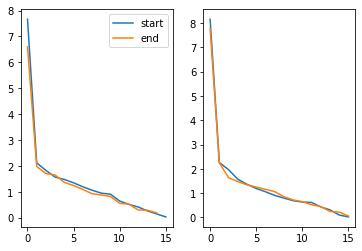

In [6]:
s_start_c,s_start_a = compute_sigmasf(T,s_cols[0][1:-1],s_rows[0][1:-1])
s_end_c,s_end_a = compute_sigmasf(T,s_cols[-1][1:-1],s_rows[-1][1:-1])

plt.subplot(1,2,1)
plt.plot(s_start_c,label="start")
plt.plot(s_end_c,label="end")
plt.legend()
plt.subplot(1,2,2)
plt.plot(s_start_a,label="start")
plt.plot(s_end_a,label="end")

In [7]:
print(np.count_nonzero(s_start_a>2)+np.count_nonzero(s_start_c>1.5))
print(np.count_nonzero(s_end_a>2)+np.count_nonzero(s_end_c>1.5))

6
6


0.47058823529411764


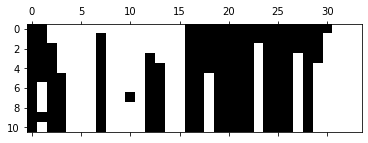

In [8]:
plt.spy(s_cols)
print(np.count_nonzero(s_cols[-1])/len(s_cols[-1]))

0.47058823529411764


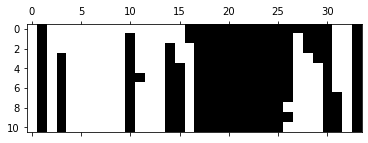

In [9]:
plt.spy(s_rows)
print(np.count_nonzero(s_cols[-1])/len(s_cols[-1]))

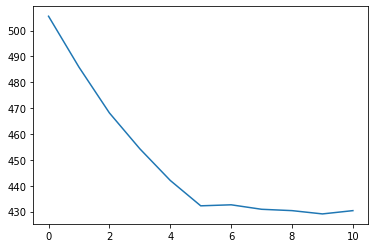

In [10]:
plt.plot(report["f"])

In [11]:
np.all(s_cols[0]==s_cols[1])

False

## Some helping function to apply permutation and store it

In [12]:
def get_permutations(s_c,s_r):
    p_col = np.hstack([np.nonzero(s_c),np.nonzero(~s_c)]).reshape(-1)
    p_row = np.hstack([np.nonzero(~s_r),np.nonzero(s_r)]).reshape(-1)
    i_in =np.count_nonzero(s_c)
    i_out=np.count_nonzero(s_r)
    return p_col,p_row,i_in,i_out

def permute_stage(stage,p_col,p_row):
    stage.B_tilde = stage.B_tilde[:,p_col]
    stage.C_tilde = stage.C_tilde[p_row,:]
    stage.D_matrix = stage.D_matrix[:,p_col][p_row]
    
def collect_permutations(P_col,P_row,k,p_col,p_row,system):
    """
    Function to collect the permutations in P_col and P_row
    
    P_col:    total permutation of columns
    P_row:    total permutation of columns
    l:        index of stage
    p_col:    new collumn permuation
    p_row:    new row permutation
    """
    
    dims_in = system.dims_in
    dims_out = system.dims_out
    
    I = np.sum(dims_in[:k]).astype(int)
    P_col[I:I+dims_in[k]]=P_col[I:I+dims_in[k]][p_col]
    I = np.sum(dims_out[:k]).astype(int)
    P_row[I:I+dims_out[k]]=P_row[I:I+dims_out[k]][p_row]

## Get test matrix

(96, 96)


<Figure size 432x288 with 0 Axes>

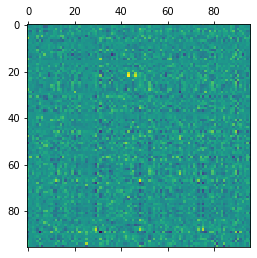

In [13]:
dims_in =  np.array([4, 4, 4, 4])*6
dims_out = np.array([4, 4, 4, 4])*6

#dims_in =  np.array([9, 7, 7, 9])*3
#dims_out = np.array([7, 9, 9, 7])*3


n = 2
#create orthogonal vectors and normalize them to the size of the matix (i.e. norm(block)/size(block) = const
Us =np.vstack([scipy.stats.ortho_group.rvs(dims_out[i])[:,:3*n]*dims_out[i] for i in range(len(dims_in))])
Vts=np.hstack([scipy.stats.ortho_group.rvs(dims_in[i])[:3*n,:]*dims_in[i] for i in range(len(dims_in))])

s = np.linspace(1,0.75,n)

lower = Us[:,:n]@np.diag(s)@Vts[:n,:]
diag = Us[:,n:2*n]@np.diag(s)@Vts[n:2*n,:]
upper = Us[:,2*n:3*n]@np.diag(s)@Vts[2*n:3*n,:]
matrix = np.zeros_like(diag)
a=0;b=0
for i in range(len(dims_in)):
    matrix[a:a+dims_out[i],:b]            =lower[a:a+dims_out[i],:b]
    matrix[a:a+dims_out[i],b:b+dims_in[i]]=diag[a:a+dims_out[i],b:b+dims_in[i]]
    matrix[a:a+dims_out[i],b+dims_in[i]:] =upper[a:a+dims_out[i],b+dims_in[i]:]
    a+=dims_out[i];b+=dims_in[i]
plt.figure()

P_in_ref = np.random.permutation(np.arange(matrix.shape[1]))
P_out_ref= np.random.permutation(np.arange(matrix.shape[0]))

T = matrix[P_out_ref][:,P_in_ref]
plt.matshow(T)
print(T.shape)

Casual Matrix shapes are correct
Anticasual Matrix shapes are correct


True

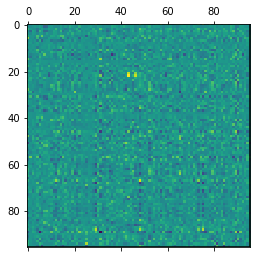

In [14]:
#T = np.random.rand(32,32)
#T =np.arange(1,32).reshape(1,-1)*np.arange(1,32).reshape(-1,1)
#T = matrix.T
#T = mats = get_mobilenet_target_mats()[0]
sys = Split.initial_sigmas_mixed(T)
utils.show_system(sys,mark_D=False)
utils.check_dims(sys)

## combine it to algorithm

In [15]:
def identification_split_system(sys,N):
    
    P_col = np.arange(np.sum(sys.dims_in) ,dtype=int)
    P_row = np.arange(np.sum(sys.dims_out),dtype=int)
    
    Ps_col =np.zeros((N,P_col.size),dtype=int)
    Ps_row =np.zeros((N,P_row.size),dtype=int)
    for n in range(N):
        print(n)
        for k in range(len(sys.causal_system.stages)-1,-1,-1): #reverse ordering makes indexing easier 
            i_in =sys.causal_system.stages[k].dim_in//2
            i_out=sys.causal_system.stages[k].dim_out//2
            Split.split_sigmas_mixed(sys,k,i_in,i_out)
    

0
1
Casual Matrix shapes are correct
Anticasual Matrix shapes are correct


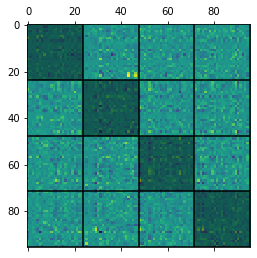

In [16]:
sys = Split.initial_sigmas_mixed(T)
identification_split_system(sys,2)
utils.check_dims(sys)
utils.show_system(sys)

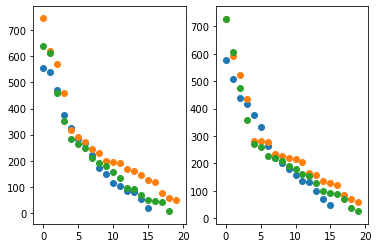

In [17]:
sigmas_causal =[stage.s_in for stage in sys.causal_system.stages][1:]
sigmas_anticausal =[stage.s_in for stage in sys.anticausal_system.stages][:-1]
#print(sigmas_causal)
#print(sigmas_anticausal)
plt.subplot(1,2,1)
for sig in sigmas_causal:
    plt.scatter(np.arange(len(sig)),sig)
plt.subplot(1,2,2)
for sig in sigmas_anticausal:
    plt.scatter(np.arange(len(sig)),sig)

In [18]:
def identification_split_clustering(sys,N,N_split = 50):
    
    P_col = np.arange(np.sum(sys.dims_in) ,dtype=int)
    P_row = np.arange(np.sum(sys.dims_out),dtype=int)
    
    Ps_col =np.zeros((N+1,P_col.size),dtype=int)
    Ps_row =np.zeros((N+1,P_row.size),dtype=int)
    Ps_col[0]=P_col
    Ps_row[0]=P_row
    reports = []
    for n in range(N):
        if not gammas is None:
            global gamma
            gamma = gammas[n]
            print("gamma =",gamma)
        for k in range(len(sys.causal_system.stages)-1,-1,-1): #reverse ordering makes indexing easier 
            stage_c=sys.causal_system.stages[k]
            stage_a=sys.anticausal_system.stages[k]
            s_c,s_r,report = segment_matrix(stage_c,stage_a,N=N_split)
            reports.append(report)
            
            assert len(s_c)==stage_c.dim_in ,"dims_in causal do not match s_c"
            assert len(s_r)==stage_c.dim_out,"dims_out causal do not match s_r"
            assert len(s_c)==stage_a.dim_in ,"dims_in antic do not match s_c"
            assert len(s_r)==stage_a.dim_out,"dims_out antic do not match s_r"
            p_col,p_row,i_in,i_out = get_permutations(s_c,s_r)
            permute_stage(stage_c,p_col,p_row)
            permute_stage(stage_a,p_col,p_row)
            collect_permutations(P_col,P_row,k,p_col,p_row,sys)
            
            Split.split_sigmas_mixed(sys,k,i_in,i_out)
        #save the Permutations collected for all stages
        Ps_col[n+1]=P_col
        Ps_row[n+1]=P_row
    
    return Ps_col,Ps_row,reports

g_prime = 9600000.0
converged at n= 30
frac cols: 0.5
frac rows: 0.4895833333333333
g_prime = 4850000.0
converged at n= 13
frac cols: 0.6458333333333334
frac rows: 0.46938775510204084
g_prime = 4750000.0
converged at n= 14
frac cols: 0.3333333333333333
frac rows: 0.5319148936170213
Casual Matrix shapes are correct
Anticasual Matrix shapes are correct


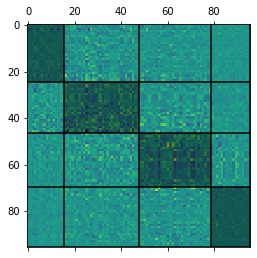

In [20]:
gamma = 1e5
gammas = None
sys = Split.initial_sigmas_mixed(T)
Ps_col,Ps_row,reports = identification_split_clustering(sys,2)
P_col = Ps_col[-1]
P_row = Ps_row[-1]
utils.check_dims(sys)
utils.show_system(sys)

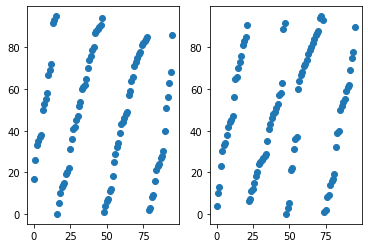

In [21]:
plt.subplot(1,2,1)
plt.scatter(np.arange(len(P_col)),P_col)
plt.subplot(1,2,2)
plt.scatter(np.arange(len(P_row)),P_row)

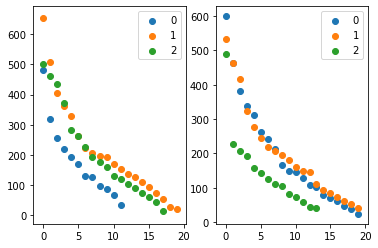

In [22]:
sigmas_causal =[stage.s_in for stage in sys.causal_system.stages][1:]
sigmas_anticausal =[stage.s_in for stage in sys.anticausal_system.stages][:-1]
#print(sigmas_causal)
#print(sigmas_anticausal)
plt.subplot(1,2,1)
for i,sig in enumerate(sigmas_causal):
    plt.scatter(np.arange(len(sig)),sig,label=str(i))
plt.legend()
plt.subplot(1,2,2)
for i,sig in enumerate(sigmas_anticausal):
    plt.scatter(np.arange(len(sig)),sig,label=str(i))
plt.legend()

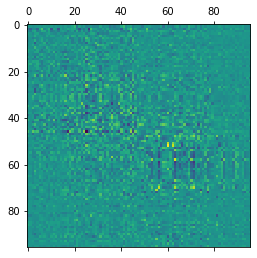

In [23]:
plt.matshow(T[P_row][:,P_col])

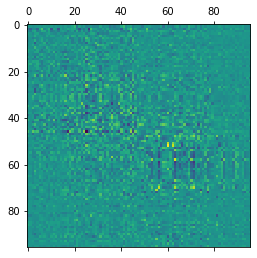

In [24]:
plt.matshow(T[Ps_row[-1]][:,Ps_col[-1]])

In [25]:
utils.check_dims(sys)

Casual Matrix shapes are correct
Anticasual Matrix shapes are correct


True

# Weight matrix form Mobilenet

In [26]:
T = get_mobilenet_target_mats()[0]

0
1
2
Casual Matrix shapes are correct
Anticasual Matrix shapes are correct


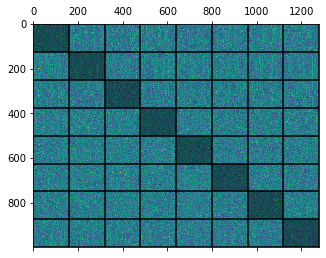

In [27]:
sys = Split.initial_sigmas_mixed(T)
identification_split_system(sys,3)
utils.check_dims(sys)
utils.show_system(sys)

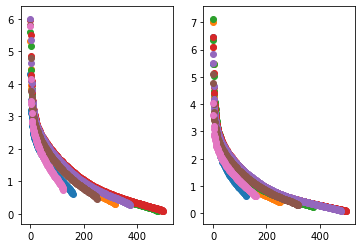

In [28]:
sigmas_causal =[stage.s_in for stage in sys.causal_system.stages][1:]
sigmas_anticausal =[stage.s_in for stage in sys.anticausal_system.stages][:-1]
#print(sigmas_causal)
#print(sigmas_anticausal)
plt.subplot(1,2,1)
for sig in sigmas_causal:
    plt.scatter(np.arange(len(sig)),sig)
plt.subplot(1,2,2)
for sig in sigmas_anticausal:
    plt.scatter(np.arange(len(sig)),sig)

gamma = 6000.0
g_prime = 6840000.0
converged at n= 81
frac cols: 0.51171875
frac rows: 0.481
gamma = 70.0
g_prime = 40040.0
converged at n= 130
frac cols: 0.6576
frac rows: 0.3333333333333333
g_prime = 39760.0
converged at n= 90
frac cols: 0.35419847328244275
frac rows: 0.6673596673596673
gamma = 20.0
g_prime = 5600.0
converged at n= 75
frac cols: 0.17289719626168223
frac rows: 0.7716763005780347
g_prime = 5840.0
flip n = 33
flip n = 36
flip n = 40
flip n = 43
flip n = 45
flip n = 47
flip n = 48
flip n = 49
flip n = 57
flip n = 58
flip n = 59
flip n = 61
flip n = 63
flip n = 64
flip n = 65
flip n = 66
flip n = 67
flip n = 68
flip n = 77
flip n = 106
flip n = 107
flip n = 108
flip n = 118
flip n = 142
flip n = 146
flip n = 147
flip n = 151
flip n = 152
flip n = 153
flip n = 154
flip n = 173
flip n = 174
flip n = 181
flip n = 182
flip n = 183
flip n = 184
flip n = 185
flip n = 187
flip n = 193
flip n = 194
flip n = 195
flip n = 196
flip n = 197
flip n = 198
flip n = 199
frac cols: 0.2408

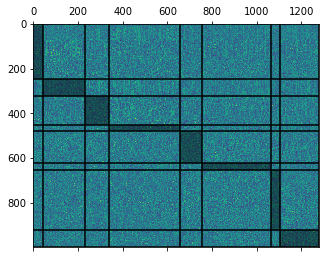

In [29]:
gamma = 6e-1
gammas = np.array([6e3,7e1,2e1])
sys_per = Split.initial_sigmas_mixed(T)
Ps_col,Ps_row,reports = identification_split_clustering(sys_per,3,N_split=200)
utils.check_dims(sys_per)
utils.show_system(sys_per)

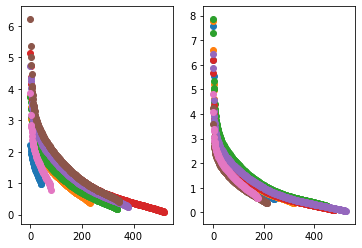

In [30]:
sigmas_causal =[stage.s_in for stage in sys_per.causal_system.stages][1:]
sigmas_anticausal =[stage.s_in for stage in sys_per.anticausal_system.stages][:-1]
#print(sigmas_causal)
#print(sigmas_anticausal)
plt.subplot(1,2,1)
for sig in sigmas_causal:
    plt.scatter(np.arange(len(sig)),sig)
plt.subplot(1,2,2)
for sig in sigmas_anticausal:
    plt.scatter(np.arange(len(sig)),sig)

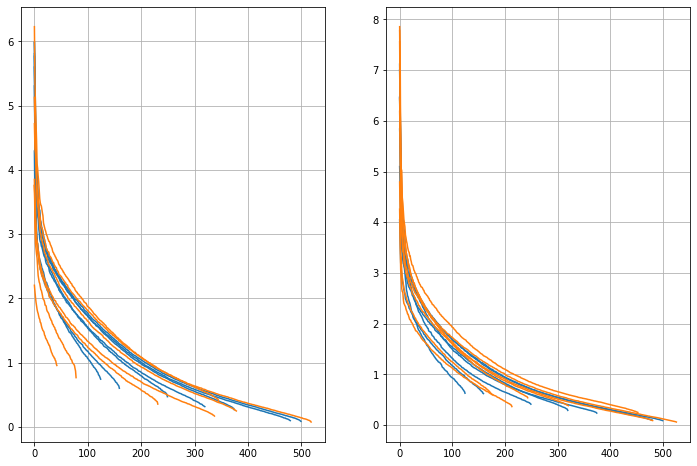

In [31]:
sigmas_causal_per =[stage.s_in for stage in sys_per.causal_system.stages][1:]
sigmas_anticausal_per =[stage.s_in for stage in sys_per.anticausal_system.stages][:-1]

sigmas_causal =[stage.s_in for stage in sys.causal_system.stages][1:]
sigmas_anticausal =[stage.s_in for stage in sys.anticausal_system.stages][:-1]

plt.figure(figsize=[12,8])

plt.subplot(1,2,1)
plt.grid()
for sig in sigmas_causal:
    plt.plot(np.arange(len(sig)),sig,color='C0')
for sig in sigmas_causal_per:
    plt.plot(np.arange(len(sig)),sig,color='C1')
plt.subplot(1,2,2)
for sig in sigmas_anticausal:
    plt.plot(np.arange(len(sig)),sig,color='C0')
for sig in sigmas_anticausal_per:
    plt.plot(np.arange(len(sig)),sig,color='C1')
plt.grid()


In [32]:
T_per = T[Ps_row[-1]][:,Ps_col[-1]]
np.max(np.abs(T_per-sys_per.to_matrix()))

1.6653345369377348e-15

In [33]:
eps_max = max([np.max(sig)for sig in sigmas_causal]+[np.max(sig)for sig in sigmas_anticausal])
print(eps_max)

7.117459986767935


In [34]:
approx =Approximation(sys,(sigmas_causal,sigmas_anticausal))
approx_per=Approximation(sys_per,(sigmas_causal_per,sigmas_anticausal_per))


N = 9 #number of points
#N = 18 #number of points
alpha = np.linspace(0,1,N)

err_move =np.zeros_like(alpha)

eps = eps_max*alpha

def calc_values(approx,eps,matrix):
    costs =np.zeros_like(eps)
    err =np.zeros_like(eps)
    for i in range(len(eps)):
        approx_system=approx.get_approxiamtion(eps[i])
        matrix_approx = approx_system.to_matrix()
        err[i] = np.linalg.norm(matrix_approx-matrix,ord=2)
        costs[i] = approx_system.cost()
    return err,costs

err_orig,cost_orig = calc_values(approx,eps,T)
err_per,cost_per = calc_values(approx_per,eps,T_per)

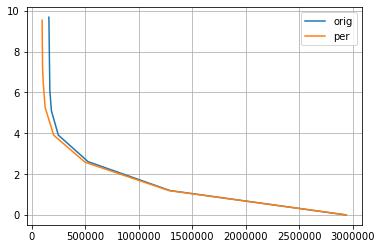

In [35]:
plt.plot(cost_orig,err_orig,label="orig")
plt.plot(cost_per,err_per,label="per")
plt.legend()
plt.grid()

In [36]:
print(eps[2])

1.7793649966919838


In [37]:
cost_orig[2]

526318.0

In [38]:
cost_per[2]

498446.0

In [39]:
i = 2
print(alpha[i])
print((1-cost_per[i]/cost_orig[i]),"%")

0.25
0.052956577582374154 %


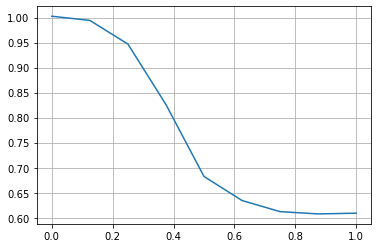

In [40]:
plt.plot(alpha,cost_per/cost_orig)
plt.grid()

In [41]:
eps[2]

1.7793649966919838

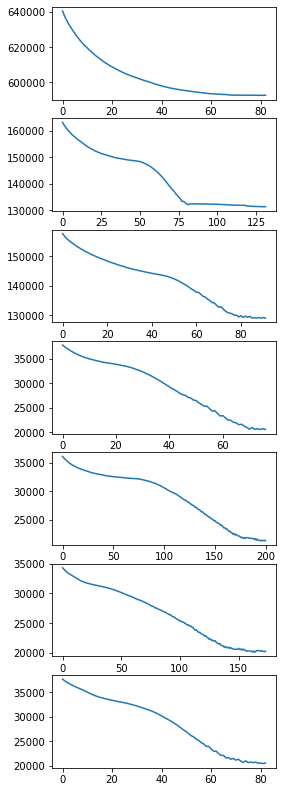

In [42]:
plt.figure(figsize = (4,2*len(reports)))
for i,report in enumerate(reports):
    plt.subplot(len(reports),1,i+1)
    plt.plot(report["f"])


In [43]:
len(reports)

7

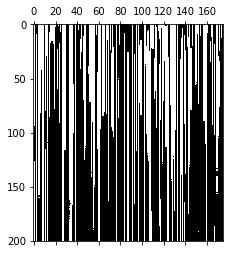

In [44]:
plt.spy(reports[4]["s_rows"])

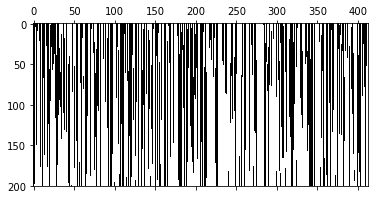

In [45]:
plt.spy(reports[4]["s_cols"])

In [46]:
reports[4]["q"]

1

In [47]:
def get_AlexNet_target_mats():
    target_mats = []
    # Load the model
    model = models.alexnet(pretrained=True)
    # Put moel into eval mode
    model.eval()
    for layer in model.classifier:
        if isinstance(layer, torch.nn.Linear):
            # Obtain the weights of this layer
            weights = layer.weight.detach().numpy()
            target_mats.append(weights)
    return target_mats
mat_AlexNet = get_AlexNet_target_mats()[0]

In [48]:
T = mat_AlexNet

In [49]:
print(sys.dims_in)
print(sys_per.dims_in)

[160, 160, 160, 160, 160, 160, 160, 160]
[43, 189, 106, 317, 99, 312, 37, 177]


In [50]:
print(sys.dims_out)
print(sys_per.dims_out)

[125, 125, 125, 125, 125, 125, 125, 125]
[244, 77, 132, 28, 140, 33, 267, 79]
